In [6]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

In [4]:
ways = jnp.array([0,3,8,9,0])

ways / jnp.sum(ways)

DeviceArray([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

Likelihood: relative ways where p can product data
prior probability - prior plausibility of a specific p.
the new updated plausibility of p is called posterior probability

In [9]:
jnp.exp(dist.Binomial(
    total_count=9,
    probs=0.5).log_prob(6))

DeviceArray(0.16406302, dtype=float32)

Prior is considered just to be part of hte model.
in practice, both evaluate the model the same way.
statistical analysis is inherently subjective.

_engineering uses math as well, but there are many ways to build the bridge_

$$W \sim Binomial(N, p) $$

Where N = W + L. W in N trials with probability p on each trial comes from a binomial distribution.

$$ p \sim Uniform(0, 1) $$
p has a uniform(flat distribiton) across all desired ranges from zero to 1

### Bayes Theorem

$$Pr(p | W, L) = Pr(W, L | p) * Pr(p) / Pr(W, L)$$ 


posterior is the probability of hte data * prior over the average probability of the data

average probability of the data can be described as evidence or average liklihood.

E means expectaion.

Posterior is proprotional to the product or prior and probability of the data

There are 3 ways to run a conditional engine, numerical techniques for computing posteriror distribtions:

1. Grid approximiation
2. Quadratic approximiation
3. MCMC(Markove chain Monte Carlo simulation)

## Gride Approximation

At any particular value of p, compute the posterior by having the prior multiply by the liklihood.
it doesn't scale as well
- not as practical as the parameters increases. 


Procedure

1. define the gridd of points
2. compute the value of the prior 
3. compute the likelihood of hte parameters
4. compute the unstndardize dposterior
5. standardize the posterior by dividng each value by the sum of the values. 

In [13]:
p_grid = jnp.linspace(start=0, stop=1, num=20)

prior = jnp.repeat(1, 20)

likelihood = jnp.exp(dist.Binomial(
    total_count=9,
    probs=p_grid
).log_prob(6))

unstd_posterior = likelihood * prior
posterior = unstd_posterior / sum(unstd_posterior)

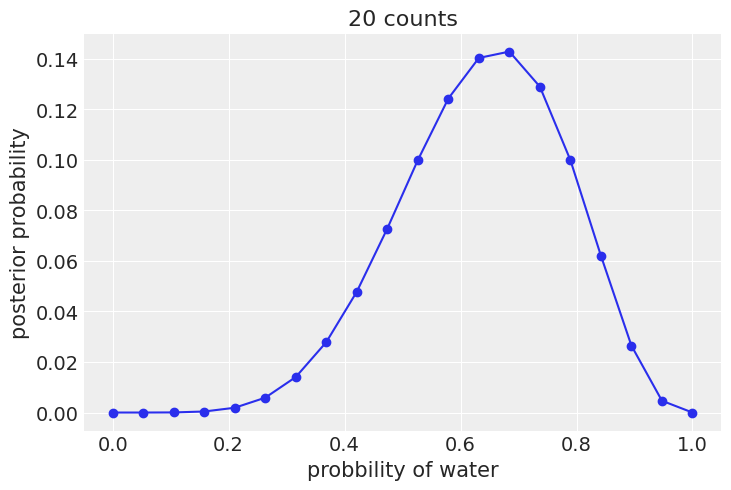

In [23]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probbility of water")
plt.ylabel("posterior probability")
plt.title("20 counts")
plt.show()

In [26]:
# this adds in the number of intervals you care about
p_grid = jnp.linspace(start=0, stop=1, num=5)

# set the constaint assumption(nothing)
prior = jnp.repeat(1, 5)

# give binoaml distribution where the probability is 
# stated and alos the number of counts are considered
likelihood = jnp.exp(dist.Binomial(
    total_count=9,
    probs=p_grid
).log_prob(6))

unstd_posterior = likelihood * prior
posterior = unstd_posterior / sum(unstd_posterior)

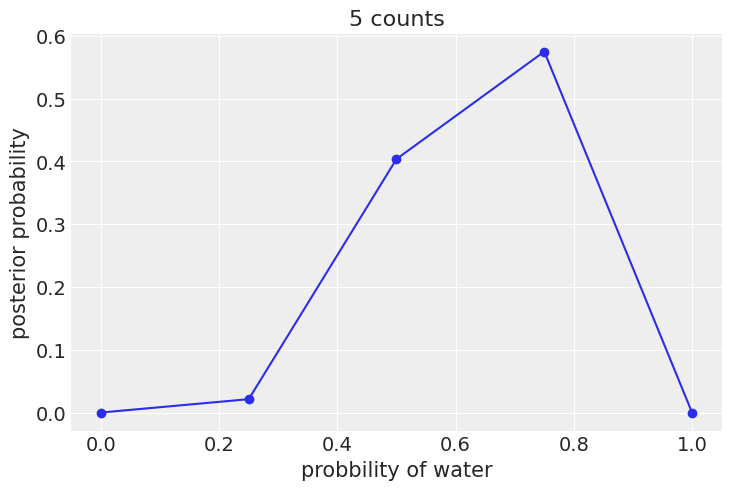

In [27]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probbility of water")
plt.ylabel("posterior probability")
plt.title("5 counts")
plt.show()

In [28]:
prior = jnp.where(p_grid <0.5 , 0, 1)
prior = jnp.exp(-5 * abs(p_grid - 0.5))

In [29]:
prior

DeviceArray([0.082085 , 0.2865048, 1.       , 0.2865048, 0.082085 ], dtype=float32)

## Quadratic Approximation

Under genral condition that the peak of the posterior distribtion will be gaussian. Posterior can be useful to approximate by the gaussian distribution. It only requires to know the location fo the center(mean) and its spread(variance)

Gaussian approximation si called quadrastic, because teh log of gaussian forms a parablola, adn the parabola is a qudradic function. 

1. find the posterior mode
2. after fine the peak, estimate the curvature near the peak 

In [31]:
def model(W, L):
    p= numpyro.sample("p", dist.Uniform(0, 1))
    W = numpyro.sample("W", dist.Binomial(W+L, p), obs=W)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=6, L=3)
params, losses = svi.run(random.PRNGKey(0), 1000)

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 937.62it/s, init loss: 2.9278, avg. loss [951-1000]: 2.7795]

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



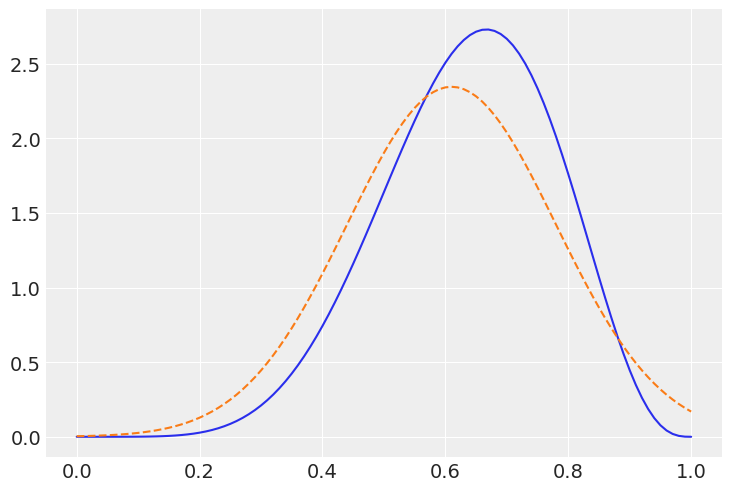

In [32]:
W = 6
L = 3
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(W+1, L+1).log_prob(x)))
plt.plot(x, jnp.exp(dist.Normal(0.61, 0.17).log_prob(x)), "--")
plt.show()

Maximum liklihood Estimate - quadrastic approximiation is equivalent to MLE and standard error.

MLE is very common non-bayesian esitmates. 

## MCMC

- responsible for resurgence of bayesian analysis.
instead of atetmpting to compute approximate the posterior directly, it draws samples from the posterior. 
ended up having colleciton of parameter values, and uses hte frequencly of the values to estimate posterior plausibilities. 

In [39]:
n_samples = 1_000
p= [jnp.nan] * n_samples

p[0] = 0.5
W=6
L=3

with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i-1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = jnp.exp(dist.Binomial(
            W+L,
            p[i-1]

        ).log_prob(W))
        q1 = jnp.exp(dist.Binomial(
            W+L,
            p_new
        ).log_prob(W))

        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]




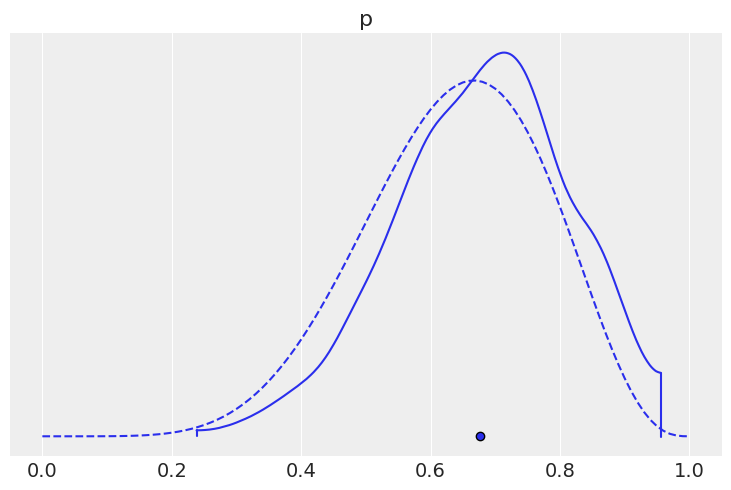

In [40]:
az.plot_density({"p": p}, hdi_prob=1)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--")
plt.show()

## Practice 2.6

E1: 2,4

E2: 3

E3: 1,4

E4: Assuming there are 10 occurence of observed event 7 out of the 10 will have rain occuring.


Givne the events: ['W', 'W', 'W']


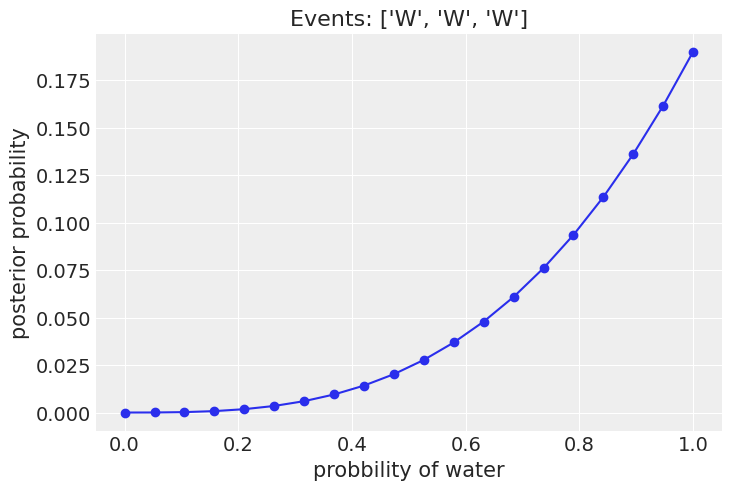

Givne the events: ['W', 'W', 'L']


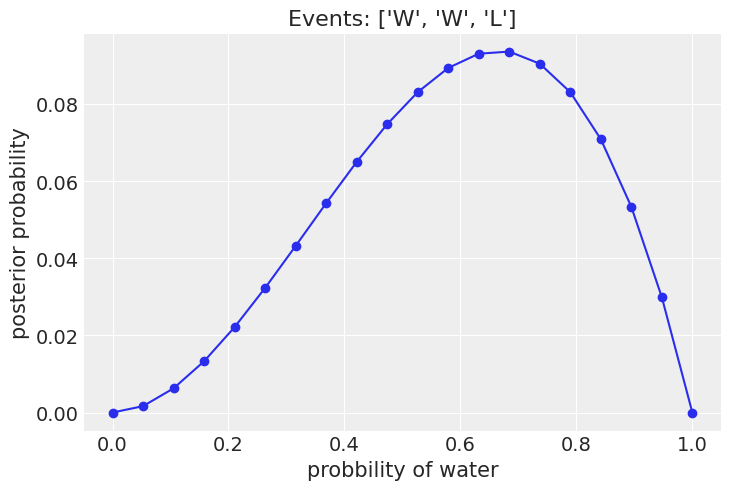

Givne the events: ['L', 'W', 'W', 'L', 'W', 'W', 'W']


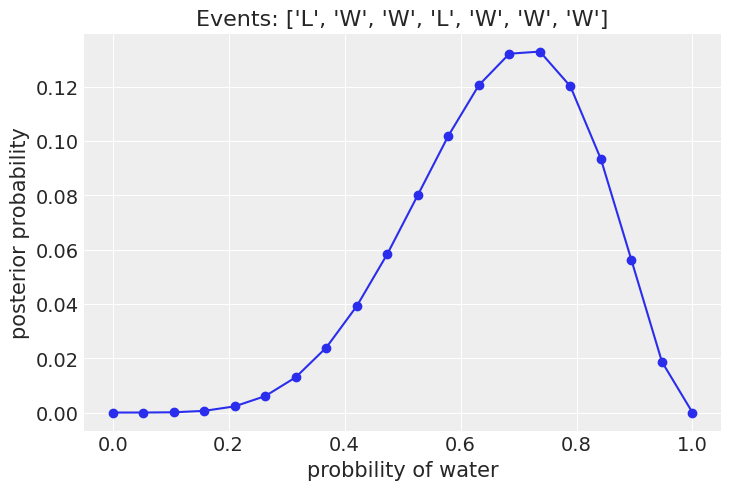

In [44]:

def grid_approx(events):
    print(f"Givne the events: {events}")
    w_len = len([x for x in events if x == 'W'])
    p_grid = jnp.linspace(start=0, stop=1, num=20)

    prior = jnp.repeat(1, 20)

    likelihood = jnp.exp(dist.Binomial(
        total_count=len(events),
        probs=p_grid
    ).log_prob(w_len))

    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / sum(unstd_posterior)

    plt.plot(p_grid, posterior, "-o")
    plt.xlabel("probbility of water")
    plt.ylabel("posterior probability")
    plt.title(f"Events: {events}")
    plt.show()


events = ["W", "W", "W"]
grid_approx(events)
grid_approx(["W", "W", "L"])
grid_approx(["L", "W", "W", "L", "W", "W", "W"])

Givne the events: ['W', 'W', 'W']


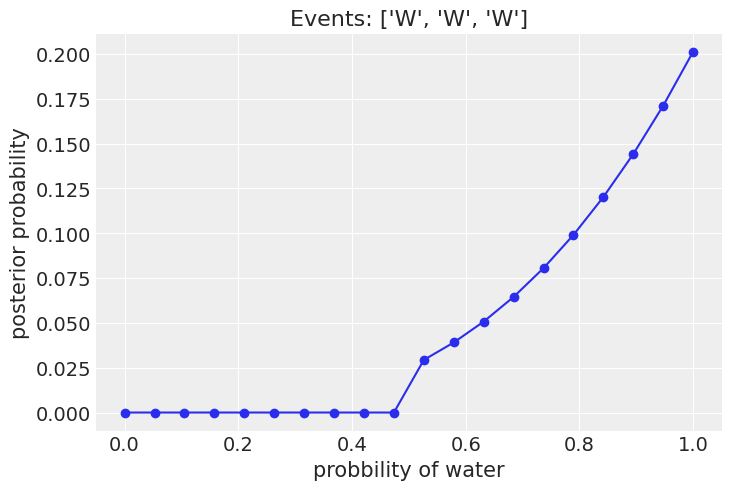

Givne the events: ['W', 'W', 'L']


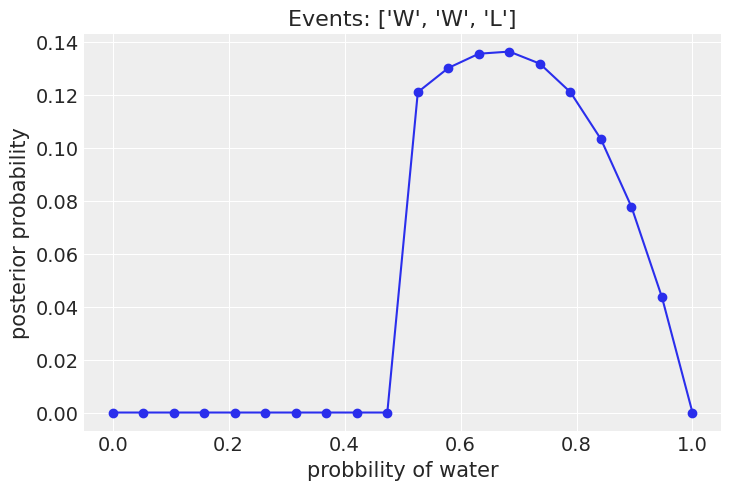

Givne the events: ['L', 'W', 'W', 'L', 'W', 'W', 'W']


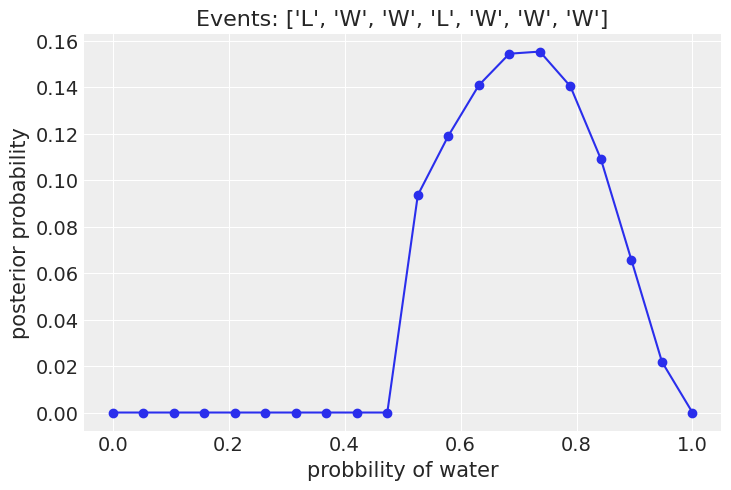

In [53]:

def grid_approx(events):
    print(f"Givne the events: {events}")
    w_len = len([x for x in events if x == 'W'])
    p_grid = jnp.linspace(start=0, stop=1, num=20)
    prior = jnp.array([0 if x < 0.5 else 1 for x in p_grid])

    likelihood = jnp.exp(dist.Binomial(
        total_count=len(events),
        probs=p_grid
    ).log_prob(w_len))

    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / sum(unstd_posterior)

    plt.plot(p_grid, posterior, "-o")
    plt.xlabel("probbility of water")
    plt.ylabel("posterior probability")
    plt.title(f"Events: {events}")
    plt.show()


events = ["W", "W", "W"]
grid_approx(events)
grid_approx(["W", "W", "L"])
grid_approx(["L", "W", "W", "L", "W", "W", "W"])

2M3

$$
Pr(Earth | land) = Pr(land | Earth) * p(Earth) / Pr(land) \\

Pr(land | Earth) = 0.3 \\

Pr(Earth) = 0.5 \\

Pr(land) = 0.5 * Pr(land|Earth) + 0.5 * Pr(land | Mars) \\
Pr(land) = 0.5 * 0.3 + 0.5 * 1 \\
$$

In [57]:
# compute prob_earth_given_land(x)
prob = (0.3 * 0.5) / ((0.5 * 0.3) + (0.5))

print(f"Probability of earth given land is : {round(prob,2)}")

Probability of earth given land is : 0.23


2M4:
There are 3 cards:
1 is both sided black
1 is one side black and one side white
1 is both side white

p(back is black | front is black)
p(bb | fb)

$$

Pr(bb) = BB / (BW + WW + BB) = 2/3
 
$$

In [65]:
card = ['bb', 'bw', 'ww']
ways = [2, 1, 0]
p = [way / len(ways) for way in ways]
p[0]

0.6666666666666666

2M5

Pr(BB) = BB + BB / (BW + WW+ BB+BB) = 4 / 5

2M6

BB: 1, 2 = 2

BW: 2, 2 = 2

WW: 3, 0

Pr(BB) = BB / (BB+BW + WW) = 1/2

2M7

BB 6, 

BW 2

WW

If the face down card is BB, there's 3 ways for the second card to show white.

if the face up card is bb, there's also 3 ways for second card is white

If the face down is BW, there's 2 ways that is coudl show up as white


6 / (3+3+2) = 0.75

In [73]:
6 / 8

0.75

2H1

$$
Pr(twin|A) = 0.1 \\
Pr(twin |B) = 0.2 \\

Pr(twin) = 0.5 * Pr(twin|A) + 0.5 Pr(twin|B) \\

Pr(twin2|twin1) = Pr(twin1, twin2) / Pr(twin) \\

Pr(twin1, twin2) = 0.5 * Pr(twin|A) * Pr(twin|A) + 0.5 * Pr(twin|B) * PR(twin|B)
$$

In [76]:
p_twin_1_twin_2 = (0.5 * 0.1 * 0.1) + (0.5*0.2*0.2)
p_twins = (0.5*0.1) + (0.5*0.2)

print(f"probabilty to have two twins in a row: {p_twin_1_twin_2 / p_twins}")

probabilty to have two twins in a row: 0.16666666666666669


2H2

$$

Pr(A|twin) = Pr(twin|A) * P(A) / Pr(twin)
$$

In [78]:
print(f"Probabilty to have species A: {(0.1*0.5) / p_twins}")

Probabilty to have species A: 0.3333333333333333


2H3
$$
Pr(A| first_child=twin, second child=single) \\

P(first_twin, second_single|A) * P(A) / Pr(first_twin, second_single)
$$

In [79]:
pr_first_twin_second_single = (0.1 * 0.9 * 0.5) + (0.5*0.2*0.8)
((0.1 * 0.9) * (0.5)) / pr_first_twin_second_single

0.36

$$
Pr(A) = 0.3 \\
Pr(B) = 0.6 \\

Pr(A|single) = Pr(single|A) * P(A) / P(single) \\

Pr(signal|A) = 0.9 \\

P(single) = 0.5 * 0.9 + 0.5 * 0.8

$$

In [80]:
(0.9*0.33333) / ((0.5*0.9) + (0.5*0.8))

0.3529376470588235

2H4

ignore

$$
p(test A|A) = 0.8 \\
p(test A|B) = 0.35 \\

P(A| test A) = p(test|A) * P(A) / p(test)
$$

In [83]:
(0.8*0.5) / ((0.5*0.8) + (0.5*0.35))

0.6956521739130436

include previous

$$
p(corrct|A) = 0.8 \\
p(correct|B) = 0.65 \\

P(A|correct) = p(correct|A) * P(A) / p(correct) \\
$$

We include the previous one by adapting the probabily of A based on the outcome of 2H3. 

In [85]:
(0.8 * 0.36) / ((0.5*0.36) + ((1-0.36)*0.5))

0.576